In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyRegressor
import xgboost as xgb

import eli5
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_hdf('../input/big_train_warsaw_property.h5')
test = pd.read_hdf('../input/test_warsaw_property.h5')

print(train.shape, test.shape)

(46489, 53) (46275, 52)


In [3]:
train.shape

(46489, 53)

In [4]:
price = train['price'] #Leaving price column unpreprocessed
train.drop('price', axis=1, inplace=True)

In [5]:
df = pd.concat([train,test])
df.shape

df['voivodeship'] = [i[0] for i in list(df['location'])]
df['city'] = [i[1] for i in list(df['location'])]


df_cracow = df[df['city']=='Kraków']

df_cracow.sample(3)

,id,location,is_private,piekarnik,garaż,monitoring / ochrona,rolety antywłamaniowe,kuchenka,taras,balkon,...,stan wykończenia,czynsz,rodzaj zabudowy,ogrzewanie,forma własności,stats,text,is_primary_market,voivodeship,city
40112,40112,"[małopolskie, Kraków, Śródmieście, Topolowa]",-1,False,False,False,False,False,False,False,...,do wykończenia,NaN,kamienica,gazowe,pełna własność,"{'ID': 110327104, 'visit_ads': '439', 'created...",Opis Do sprzedania mieszkanie o powierzchni 23...,False,małopolskie,Kraków
29511,29511,"[małopolskie, Kraków, Kleparz]",0,False,False,True,False,False,False,True,...,NaN,127 zł,kamienica,NaN,NaN,"{'ID': 112449968, 'visit_ads': '259', 'created...",Opis Kupując u nas - nie zapłacisz prowizji! K...,False,małopolskie,Kraków
36460,36460,"[małopolskie, Kraków, Prądnik Biały]",0,False,False,False,False,False,False,True,...,NaN,350 zł,blok,miejskie,NaN,"{'ID': 110927736, 'visit_ads': '202', 'created...",Opis Kupując u nas- nie zapłacisz prowizji! Co...,False,małopolskie,Kraków


In [ ]:
from scipy.stats import iqr

mean = np.mean(price)
max = np.max(price)
min = np.min(price)
std = np.std(price)
q_1 = np.quantile(price, .25)
median = np.quantile(price, .50)
q_3 = np.quantile(price, .75)
iqr = iqr(price) #odleglosc absolutna miedzy Q_1 i Q_3

print('Mean: {}'.format(mean))
print('max: {}'.format(max))
print('min: {}'.format(min))
print('std: {}'.format(std))
print('Q_1: {}'.format(q_1))
print('Median: {}'.format(median))
print('Q_3: {}'.format(q_3))
print('Odległość abbsolutna miedzy Q_1 i Q_3: {}'.format(iqr))

### Changing type of columns

In [7]:
df_cracow.drop('id', axis=1, inplace=True)
df_cracow.drop('location', axis=1, inplace=True)
df_cracow.drop('voivodeship', axis=1, inplace=True)
df_cracow.drop('city', axis=1, inplace=True)
df_cracow.drop('stats', axis=1, inplace=True)
df_cracow.drop('text', axis=1, inplace=True)
df_cracow.drop('dostępne od', axis=1, inplace=True)

In [8]:
df_cracow['czynsz'] = df_cracow['czynsz'].str.replace(' zł','')
df_cracow['czynsz'] = df_cracow['czynsz'].str.replace(' ','')
df_cracow['czynsz'] = df_cracow['czynsz'].fillna('0')
df_cracow['czynsz'] = df_cracow['czynsz'].map(lambda x: x.replace(',','.'))
df_cracow['czynsz'] = df_cracow['czynsz'].str.replace('_','')
df_cracow['czynsz'] = df_cracow['czynsz'].str.replace('eur','')

df_cracow['czynsz'] = [float(c) for c in df_cracow['czynsz']]
df_cracow['czynsz']

19699      0.0
19746      0.0
19747      0.0
19748      0.0
19752      0.0
         ...  
51077    470.0
51081    590.0
51130    260.0
51132      0.0
51134    460.0
Name: czynsz, Length: 9002, dtype: float64

In [9]:
df_cracow['rok budowy'] = df_cracow['rok budowy'].fillna(0)
df_cracow['rok budowy'] = df_cracow['rok budowy'].astype(int)
df_cracow['rok budowy']

19699       0
19746       0
19747       0
19748       0
19752       0
         ... 
51077    2018
51081    1935
51130       0
51132    2018
51134    1910
Name: rok budowy, Length: 9002, dtype: int64

### Dealing with string/object columns

In [10]:
print(df_cracow['floor'].value_counts(), '\n')

floors = pd.get_dummies(df_cracow['floor'], prefix = 'floor', drop_first=True)

df_cracow = pd.concat([df_cracow,floors], axis=1)
df_cracow.drop('floor', axis=1, inplace=True)

1           2002
2           1563
3           1382
parter      1321
4            773
5            341
6            242
7            128
8             97
10            80
9             58
> 10          56
poddasze      22
suterena      13
Name: floor, dtype: int64 



In [11]:
print(df_cracow['materiał budynku'].value_counts(), '\n')

materiał_budynku = pd.get_dummies(df_cracow['materiał budynku'], prefix = 'materiał_budynku', drop_first=True)

df_cracow = pd.concat([df_cracow,materiał_budynku], axis=1)
df_cracow.drop('materiał budynku', axis=1, inplace=True)

cegła              2376
pustak              772
inne                384
wielka płyta        219
żelbet              127
silikat              40
beton                37
beton komórkowy      23
drewno               11
Name: materiał budynku, dtype: int64 



In [12]:
print(df_cracow['okna'].value_counts(), '\n')

okna = pd.get_dummies(df_cracow['okna'], prefix = 'okna', drop_first=True)

df_cracow = pd.concat([df_cracow,okna], axis=1)
df_cracow.drop('okna', axis=1, inplace=True)

plastikowe    5216
drewniane     1407
aluminiowe     104
Name: okna, dtype: int64 



In [13]:
print(df_cracow['stan wykończenia'].value_counts(), '\n')

stan_wykończenia = pd.get_dummies(df_cracow['stan wykończenia'], prefix = 'stan_wykończenia', drop_first=True)

df_cracow = pd.concat([df_cracow,stan_wykończenia], axis=1)
df_cracow.drop('stan wykończenia', axis=1, inplace=True)

do wykończenia     1849
do zamieszkania    1786
do remontu          354
Name: stan wykończenia, dtype: int64 



In [14]:
print(df_cracow['rodzaj zabudowy'].value_counts(), '\n')

rodzaj_zabudowy = pd.get_dummies(df_cracow['rodzaj zabudowy'], prefix = 'rodzaj_zabudowy', drop_first=True)

df_cracow = pd.concat([df_cracow,rodzaj_zabudowy], axis=1)
df_cracow.drop('rodzaj zabudowy', axis=1, inplace=True)

blok                3619
apartamentowiec     1958
kamienica           1690
dom wolnostojący     157
szeregowiec          100
plomba                 8
Name: rodzaj zabudowy, dtype: int64 



In [15]:
print(df_cracow['ogrzewanie'].value_counts(), '\n')

ogrzewanie = pd.get_dummies(df_cracow['ogrzewanie'], prefix = 'ogrzewanie', drop_first=True)

df_cracow = pd.concat([df_cracow,ogrzewanie], axis=1)
df_cracow.drop('ogrzewanie', axis=1, inplace=True)

miejskie         3533
gazowe           1014
inne              304
elektryczne       205
kotłownia         160
piece kaflowe       3
Name: ogrzewanie, dtype: int64 



In [16]:
print(df_cracow['forma własności'].value_counts(), '\n')

forma_własności = pd.get_dummies(df_cracow['forma własności'], prefix = 'forma własności', drop_first=True)

df_cracow = pd.concat([df_cracow,forma_własności], axis=1)
df_cracow.drop('forma własności', axis=1, inplace=True)

pełna własność               5319
spółdzielcze własnościowe     259
spółdzielcze wł. z kw         109
udział                         56
Name: forma własności, dtype: int64 



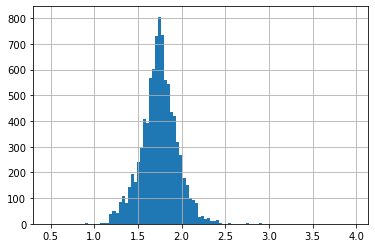

In [17]:
df_cracow['area'] = df_cracow['area'].map(lambda x: x.split('m')[0].replace(',','.').replace(' ','')).astype('float')
np.log10(df_cracow['area']).hist(bins=100)
plt.show()

In [18]:
df_cracow['floors_in_building'] = df_cracow['floors_in_building'].map(lambda x: x.split('z')[-1].replace(')','') if str(x) != 'nan' else -1).astype('float')
print(df_cracow['floors_in_building'].value_counts())

 4.0     2067
 3.0     1926
 5.0      993
-1.0      924
 2.0      850
 6.0      525
 10.0     492
 7.0      371
 1.0      360
 9.0      168
 8.0      159
 11.0      84
 14.0      18
 15.0      18
 13.0      17
 16.0      15
 12.0      14
 17.0       1
Name: floors_in_building, dtype: int64


In [19]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

df_cracow_columns = df_cracow.columns
df_cracow = scaler.fit_transform(df_cracow)

df_cracow = pd.DataFrame(df_cracow, columns = df_cracow_columns)


### Nan

In [20]:
import missingno as msno

<AxesSubplot:>

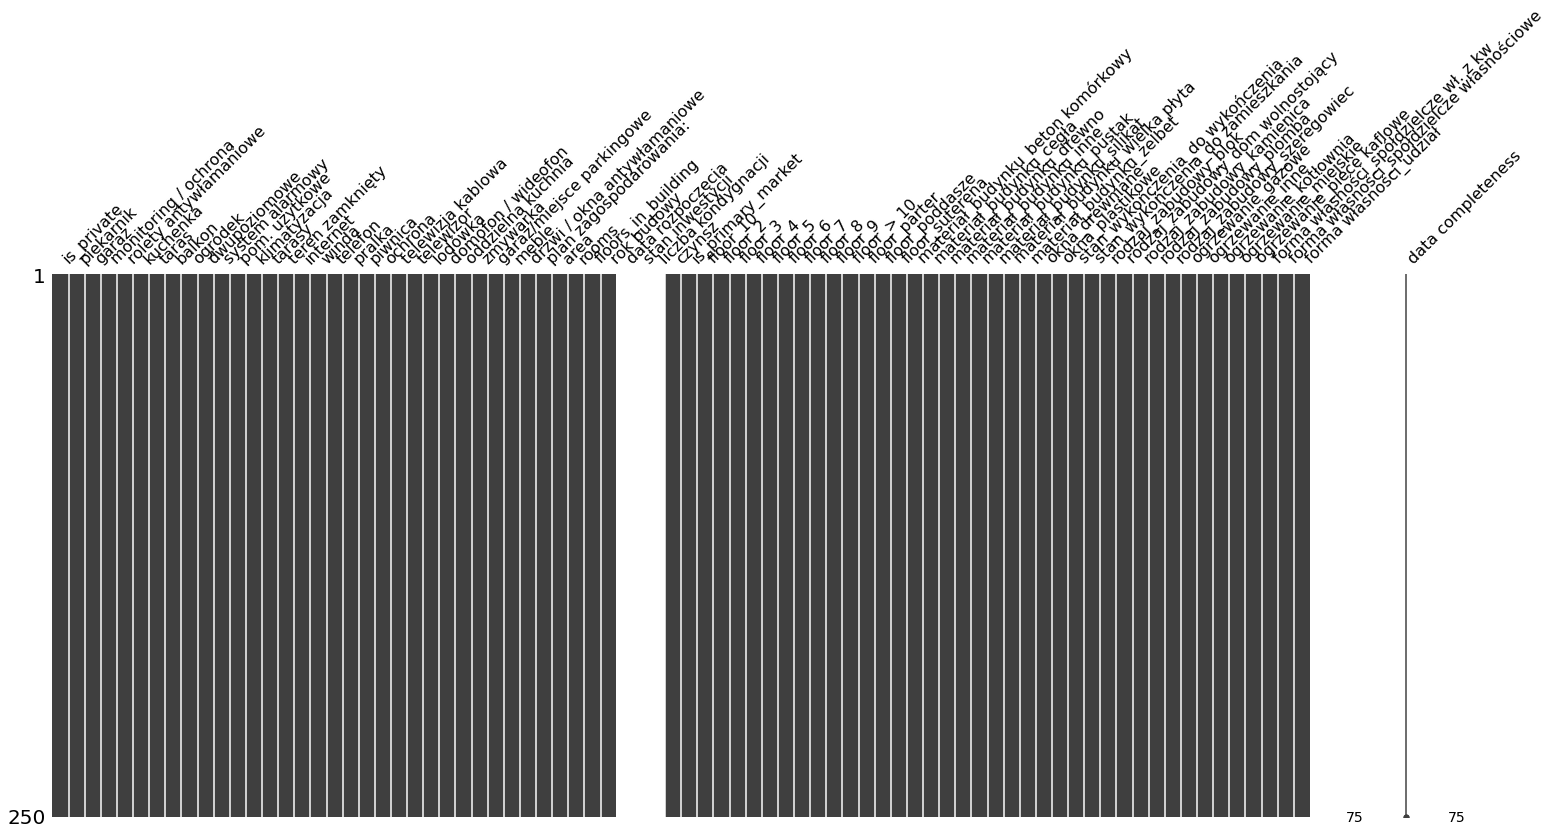

In [21]:
msno.matrix(df_cracow.sample(250), labels=True)

In [22]:
# Delete columns containing either 50% or more than 50% NaN Values
perc = 90
min_count =  int(((100-perc)/100)*df_cracow.shape[0] + 1)
df_cracow = df_cracow.dropna( axis=1, 
                thresh=min_count)

In [23]:
#from sklearn.impute import SimpleImputer

#df_cracow_cat = df_cracow.select_dtypes('object').values
#df_cracow_num = df_cracow.select_dtypes(exclude=['object','bool']).values

#simple_imputer_cat = SimpleImputer(strategy='most_frequent')
#simple_imputer_num = SimpleImputer()

#df_cracow_cat_impute = simple_imputer_cat.fit_transform(df_cracow_cat)
#simple_imputer_num_impute = simple_imputer_num.fit_transform(simple_imputer_num)

In [24]:
#for feat in df_cracow.select_dtypes('object'):
#    try:
#        df_cracow[feat] = df_cracow[feat].fillna(df_cracow[feat].value_counts().index[0])
##        print('filling missing values in column: {}'.format(feat))
#    except:
#        print('cannot filled missing values in column: {}'.format(feat))

In [25]:
#for feat in df_cracow.select_dtypes(exclude=['object','bool']):
#    try:
#        df_cracow[feat] = df_cracow[feat].fillna(df_cracow[feat].mean())
#        print('filling missing values in column: {}'.format(feat))
#    except:
#        print('cannot filled missing values in column: {}'.format(feat))

In [26]:
for feat in df_cracow.select_dtypes(bool):
    try:
        df_cracow[feat] = df_cracow[feat].astype(int)
        print('changing {} column\'s type to int'.format(feat))
    except:
        print('cannot change {} column\'s type to int' .format(feat))

<AxesSubplot:>

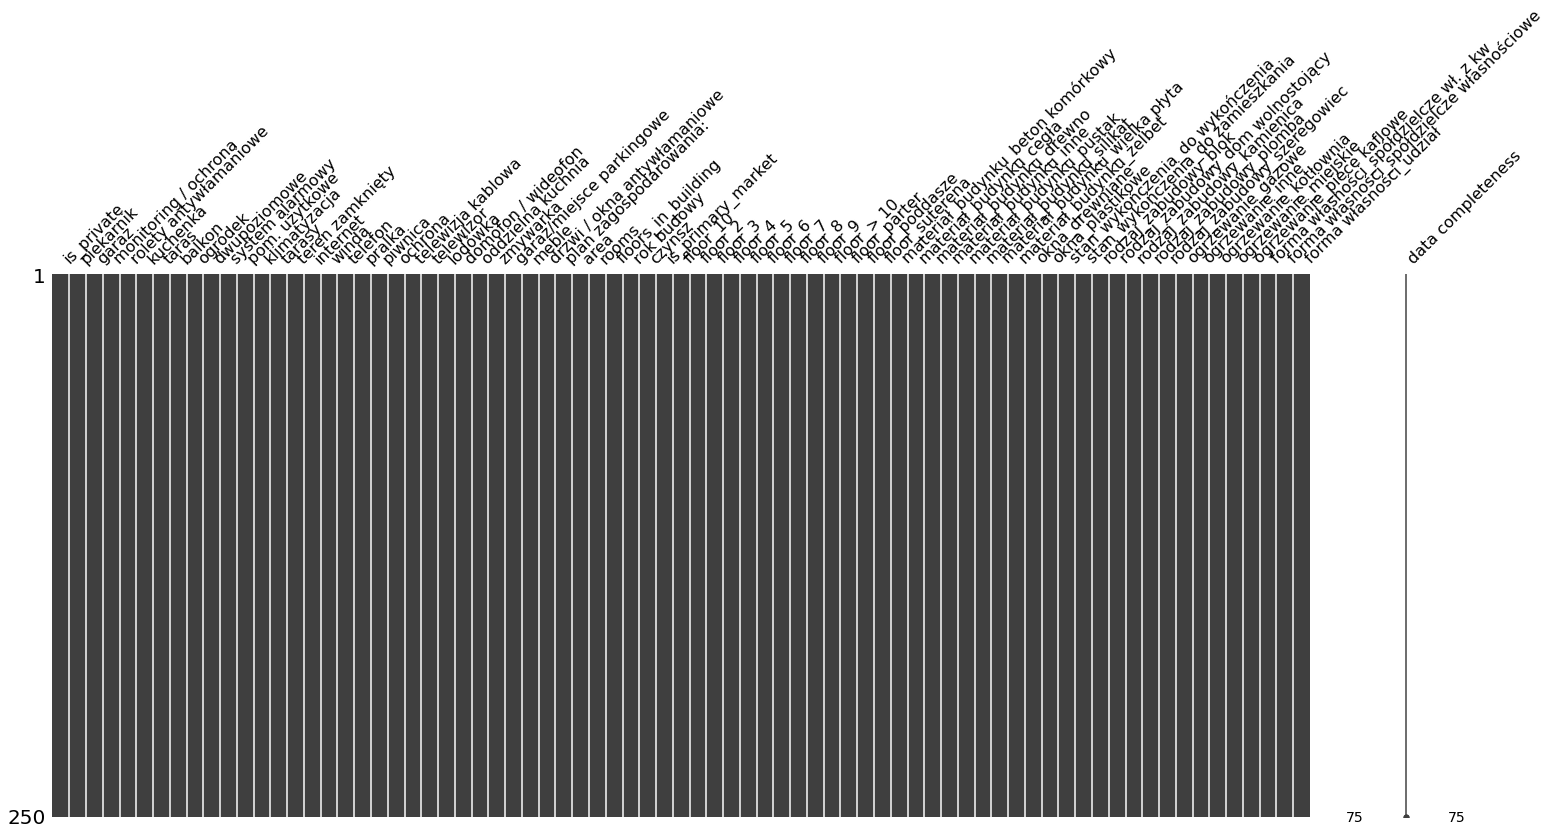

In [27]:
msno.matrix(df_cracow.sample(250), labels=True)

### Selecting Features with PCA

In [28]:
#Checking how many numeric features we have
num_feats = df_cracow.select_dtypes('number').columns
print(len(num_feats))

75


In [29]:
df_cracow['price'] = price

y = df_cracow['price'].dropna()

X = df_cracow[~df_cracow['price'].isna()]
X.drop('price', axis=1, inplace=True)

X_test = df_cracow[df_cracow['price'].isna()]
X_test.drop('price', axis=1, inplace=True)

<BarContainer object of 57 artists>

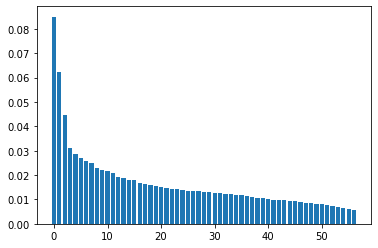

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)

X_pca = pca.fit_transform(X)
X = pca.inverse_transform(X_pca)

X_test_pca = pca.transform(X_test)
X_test = pca.inverse_transform(X_test_pca)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.35)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, )

(2923, 75) (1574, 75) (2923,) (1574,)


### First Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

model_linear_regression = LinearRegression()
model_linear_regression.fit(X_train,y_train)

y_pred_train = model_linear_regression.predict(X_train)
y_pred_valid = model_linear_regression.predict(X_valid)

print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

### Regularization and Hyperparameter tuning

In [33]:
from sklearn.model_selection import RandomizedSearchCV, KFold

kf = KFold(n_splits=10, shuffle=True, random_state=123)

params = {'alpha':np.linspace(0.01,2,20)}


In [34]:
from sklearn.linear_model import Ridge

model_ridge = Ridge()
model_ridge.fit(X_train,y_train)

y_pred_train = model_ridge.predict(X_train)
y_pred_valid = model_ridge.predict(X_valid)

print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

MAE on train dataset: 106409.0434983119
MAE on valid dataset: 114881.0930425265


In [35]:
ridge_cv = RandomizedSearchCV(model_ridge, params, cv=kf)
ridge_cv.fit(X_train,y_train)

y_pred_train = ridge_cv.predict(X_train)
y_pred_valid = ridge_cv.predict(X_valid)

print('Best params: {}'.format(ridge_cv.best_params_))
print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

Best params: {'alpha': 0.9526315789473684}
MAE on train dataset: 106409.22926657685
MAE on valid dataset: 115045.26218075033


In [36]:
from sklearn.linear_model import Lasso

model_lasso = Lasso()
model_lasso.fit(X_train,y_train)

y_pred_train = model_lasso.predict(X_train)
y_pred_valid = model_lasso.predict(X_valid)

print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

MAE on train dataset: 106431.60932004318
MAE on valid dataset: 121079.07679233965


In [38]:
lasso_cv = RandomizedSearchCV(model_lasso, params, cv=kf)
lasso_cv.fit(X_train,y_train)

y_pred_train = lasso_cv.predict(X_train)
y_pred_valid = lasso_cv.predict(X_valid)

print('Best params: {}'.format(lasso_cv.best_params_))
print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

Best params: {'alpha': 0.9526315789473684}
MAE on train dataset: 106430.52131291693
MAE on valid dataset: 120941.28565872462


### Creating and tuning DecisionTreeRegressor

In [40]:
from sklearn.tree import DecisionTreeRegressor

tr = DecisionTreeRegressor(random_state=123)
tr.fit(X_train,y_train)

y_pred_train = tr.predict(X_train)
y_pred_valid = tr.predict(X_valid)

print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

MAE on train dataset: 2188.574034952674
MAE on valid dataset: 159202.72311090375


In [41]:
params_tr = {
    'max_depth': [2,3,4,5,6],
    'min_samples_leaf': np.linspace(0.05,0.25,20)
}

tr_cv = RandomizedSearchCV(tr, params_tr, cv=kf)
tr_cv.fit(X_train,y_train)

y_pred_train = tr_cv.predict(X_train)
y_pred_valid = tr_cv.predict(X_valid)

print('Best params: {}'.format(tr_cv.best_params_))
print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

Best params: {'min_samples_leaf': 0.25, 'max_depth': 3}
MAE on train dataset: 107090.38590165722
MAE on valid dataset: 106634.77553519617


### Bagging with DecisionTreeRegresson as base estimator

In [42]:
from sklearn.ensemble import BaggingRegressor

br = BaggingRegressor(base_estimator=tr,
                     n_estimators=200,
                     oob_score=True #scoring on unused values
                     )
br.fit(X_train,y_train)

y_pred_train = br.predict(X_train)
y_pred_valid = br.predict(X_valid)

print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

MAE on train dataset: 43910.70382718298
MAE on valid dataset: 115394.41491092906


### RandomForestRegressor

In [45]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

params_rfr = {
    'n_estimators': np.arange(50,350,50),
    'max_depth': [2,3,4,5,6],
    'min_samples_leaf': np.linspace(0.05,0.25,20)
}

rfr_cv = RandomizedSearchCV(rfr, params_rfr, cv=kf)
rfr_cv.fit(X_train,y_train)

y_pred_train = rfr_cv.predict(X_train)
y_pred_valid = rfr_cv.predict(X_valid)

print('Best params: {}'.format(rfr_cv.best_params_))
print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

Best params: {'n_estimators': 150, 'min_samples_leaf': 0.25, 'max_depth': 4}
MAE on train dataset: 106986.2839722261
MAE on valid dataset: 105732.40889229861


### AdaBoostRegressor and GradientBoostRegressor

In process of creating Adaptive Boosting Regressor I will use the randomforestregressor that I tuned before.

In [54]:
from sklearn.ensemble import AdaBoostRegressor #Adaptive Boosting

rfr = RandomForestRegressor(n_estimators = 150,
                            min_samples_leaf = 0.25,
                            max_depth = 4)

ada_rfr = AdaBoostRegressor(base_estimator=rfr)

params_ada_rfr = {
    'n_estimators': np.arange(50,350,50),
}

ada_rfr_cv = RandomizedSearchCV(ada_rfr, params_ada_rfr, cv=kf, n_jobs=-1)
ada_rfr_cv.fit(X_train,y_train)

y_pred_train = ada_rfr_cv.predict(X_train)
y_pred_valid = ada_rfr_cv.predict(X_valid)

print('Best params: {}'.format(ada_rfr_cv.best_params_))
print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

Best params: {'n_estimators': 150}
MAE on train dataset: 160619.663380474
MAE on valid dataset: 160900.98428268047


I will create two Gradient Boosting Models. 
In first model I will use hyperparameter that I found during RandomForestRegressor's hyperparameters tuning. 
At the second model I will use RandomSearchCV model again.

In [57]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_r = GradientBoostingRegressor(n_estimators = 150,
                                min_samples_leaf = 0.25,
                                max_depth = 4)

gradient_r.fit(X_train,y_train)

y_pred_train = gradient_r.predict(X_train)
y_pred_valid = gradient_r.predict(X_valid)

print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

MAE on train dataset: 103578.63081938827
MAE on valid dataset: 106559.6101498731


In [61]:
gradient_r = GradientBoostingRegressor()

params_gradient_r = {
    'n_estimators': np.arange(50,350,50),
    'min_samples_leaf': np.linspace(0.05,0.25,20),
    'max_depth': [2,3,4,5,6],
}

gradient_r_cv = RandomizedSearchCV(gradient_r, params_gradient_r, cv=kf, n_jobs=-1)
gradient_r_cv.fit(X_train,y_train)

y_pred_train = gradient_r_cv.predict(X_train)
y_pred_valid = gradient_r_cv.predict(X_valid)

print('Best params: {}'.format(gradient_r_cv.best_params_))
print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

Best params: {'n_estimators': 100, 'min_samples_leaf': 0.23947368421052634, 'max_depth': 5}
MAE on train dataset: 104227.71690005576
MAE on valid dataset: 106235.37032777675


### XGBoost Regression

In [67]:
xgbr = xgb.XGBRegressor()

params_xgbr = {'n_estimators': np.arange(50,350,50),
          'max_depth': [2,3,4,5,6],
         'learning_rate':[0.01,0.1,0.5,0.9],
         'subsample':[0.3,0.5,0.9]}

xgbr_cv = RandomizedSearchCV(xgbr, params_xgbr, cv=kf, n_jobs=-1)

xgbr_cv.fit(X_train,y_train)

y_pred_train = xgbr_cv.predict(X_train)
y_pred_valid = xgbr_cv.predict(X_valid)

print('Best params: {}'.format(xgbr_cv.best_params_))
print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

Best params: {'subsample': 0.5, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.01}
MAE on train dataset: 100018.3671875
MAE on valid dataset: 104630.9296875
